# ECG Heartbeat Classification EDA
### Background information
- **Electrocardiogram(ECG)** measures the hearts electrical activity of the heart.
- According to (Kachuee et al., 2018), Manual ECG review are difficult when detecting and categorizing different waveform and morphologies

#### How does a heartbeat look like in a ECG signal?

To answer that, we must understand the different parts of the wave:
* __P-wave__: Starts the heartbeat, the atria(upper chamber) is contracting
* __PR interval__: Repersents the time it takes for the electical move between the __atria and the ventricle__. This time repersents the heart __natural pacemaker__.
* __QRS Complex__: Basically the beat, the sharp spike, this is when the __ventricle__ contracts and pushes blood through the body
* __ST segment__: The heart is basically relaxing here before the next heartbeat
* __T wave__: The final wave -- repolarization of the ventricles, preparing for the next heart beat

These shapes are what the machine learning model will learn to predict what is __normal__ vs __abnormal__.

### Figure 1
![ECG Heartbeat](./images/heatbeat.png)

### Objective -- what are we trying to look for?
- We want the machine learning model to know the  __statistical and morphological differences__, such that it can __reliably detects anomalies__ within the waves, and those anomolies can be classified.

### Imports

In [1]:
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.fft import rfft, rfftfreq
from scipy.signal import find_peaks
from scipy.stats import kurtosis, skew, zscore
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

### Constants

In [2]:
FS = 125
LABEL_COL = 187
RANDOM_SEED = 42
CLASSIFICATION_COL = 186

## EDA
- both mitbih and ptbdb contain enough data to train a deep learning model.
- I believe the ptbdb contains categories that contains heart attacks -- myocardial infractions
- Also, the last column should indicate what the heart beat is classified as

### Dataset Summary

In [3]:
# Paths to data ECG_Classification/.data/mitbih_train.csv
normal_train_path = "./.data/ptbdb_normal.csv"
abnormal_train_path = "./.data/ptbdb_abnormal.csv"
normal_df = pd.read_csv(normal_train_path, header=None)
abnormal_df = pd.read_csv(abnormal_train_path, header=None)
df = pd.concat([normal_df, abnormal_df], axis=0)

In [4]:
normal_df.shape, abnormal_df.shape

((4046, 188), (10506, 188))

In [5]:
normal_df.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,1.000000,0.900324,0.358590,0.051459,0.046596,0.126823,0.133306,0.119125,0.110616,0.113047,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.000000,0.794681,0.375387,0.116883,0.000000,0.171923,0.283859,0.293754,0.325912,0.345083,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.909029,0.791482,0.423169,0.186712,0.000000,0.007836,0.063032,0.077002,0.074957,0.077342,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.478893,0.056760,0.064176,0.081289,0.072732,0.055619,0.048774,0.054478,0.041643,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.000000,0.867238,0.201360,0.099349,0.141336,0.120934,0.108516,0.096393,0.093436,0.100828,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
classes_freq = normal_df.iloc[:, -1].value_counts()
sorted_classes_freq = classes_freq.sort_index()
sorted_classes_freq

187
0.0    4046
Name: count, dtype: int64

In [7]:
classes_freq = abnormal_df.iloc[:, -1].value_counts()
sorted_classes_freq = classes_freq.sort_index()
sorted_classes_freq

187
1.0    10506
Name: count, dtype: int64

__Arrhythmia dataset__
* __Total Samples__: 4045(Normal Samples) + 10505(Abnormal Samples) = 14550 Samples/Rows
* __Classes__: Abnormal(1) and Normal(0)

### General Data Cleaning
- Checking for missing values.
- No need to check for duplicate values for columns because signals is periodic wave, therefore, their should be duplicates.
- I am going to stick with float 32 percision because that is sufficent enough.


In [8]:
assert normal_df.isna().sum().sum() == 0
print("No missing values in normal data!")

No missing values in normal data!


In [9]:
assert abnormal_df.isna().sum().sum() == 0
print("No missing value in abnormal data!")

No missing value in abnormal data!


In [10]:
print("Normal Data Column Types:")
normal_df.dtypes

Normal Data Column Types:


0      float64
1      float64
2      float64
3      float64
4      float64
        ...   
183    float64
184    float64
185    float64
186    float64
187    float64
Length: 188, dtype: object

In [11]:
print("Abnormal Data Column Types:")
abnormal_df.dtypes

Abnormal Data Column Types:


0      float64
1      float64
2      float64
3      float64
4      float64
        ...   
183    float64
184    float64
185    float64
186    float64
187    float64
Length: 188, dtype: object

In [12]:
# Since all the columns are numerical, we will change them all into float32
normal_df = normal_df.astype("float32")
normal_df.dtypes

0      float32
1      float32
2      float32
3      float32
4      float32
        ...   
183    float32
184    float32
185    float32
186    float32
187    float32
Length: 188, dtype: object

In [13]:
abnormal_df = abnormal_df.astype("float32")
abnormal_df.dtypes

0      float32
1      float32
2      float32
3      float32
4      float32
        ...   
183    float32
184    float32
185    float32
186    float32
187    float32
Length: 188, dtype: object

### Question I Want to Answer To:
- Are their outliers within groups? -- use of z-scores


Before we statically find outliers or see if the groups are statistically different. Let us first see it __visually__ by __selecting two random ECG signal from each dataset(i.e., Normal and Abnormal)__. We choose at random, two from the same dataset to see if we can see variation visually. Then we are getting for each datasets to see if they look different from each other. The code below does the following.

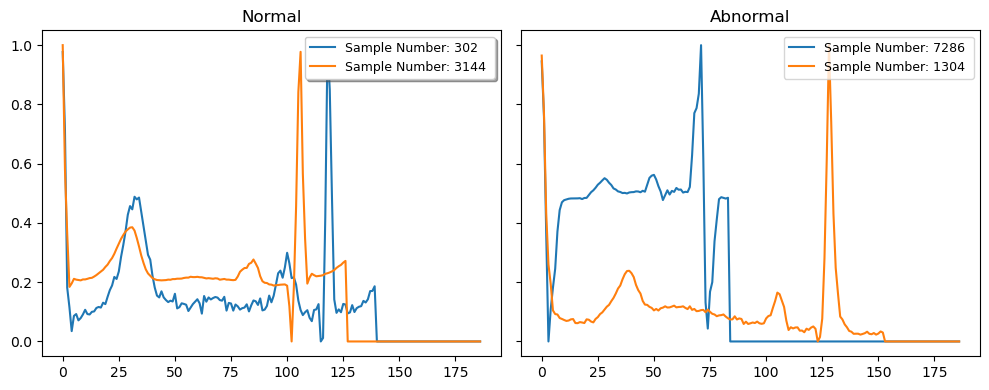

In [14]:
def visualize_differences_with_line_graph(
    normal: pd.DataFrame, abnormal: pd.DataFrame
) -> None:
    """Visualize differences within group and between groups.

    The signals are chosen at random.

    Args:
      normal : pd.DataFrame
        Dataframe that contains the normal ECG signal of a heart.
      abnormal : pd.DataFrame
        Dataframe that contains the abnormal ECG signal of a heart.

    Returns:
     Two plots, one for abnormal and the other for normal. Each
     containing two signals.
    """
    two_rand_numbers = 2
    # Tell us which signal we are choosing
    first_within_signal = 0
    second_within_signal = 1
    first_between_signal = 0
    second_betwee_signal = 1

    # Randomly chooses a signal
    choose_rand_normal_signal = np.random.randint(0, len(normal), two_rand_numbers)
    choose_rand_abnormal_signal = np.random.randint(0, len(abnormal), two_rand_numbers)
    # Plotting
    first_plot = 1
    second_plot = 2
    fig, axes = plt.subplots(first_plot, second_plot, sharey=True, figsize=(10, 4))

    # Normal signal plotting
    axes[first_between_signal].plot(
        normal.iloc[choose_rand_normal_signal[first_within_signal], :-1].values,
        label=f"Sample Number: {choose_rand_normal_signal[first_within_signal]} ",
    )
    # Second normal signal
    axes[first_between_signal].plot(
        normal.iloc[choose_rand_normal_signal[second_within_signal], :-1].values,
        label=f"Sample Number: {choose_rand_normal_signal[second_within_signal]} ",
    )
    axes[first_between_signal].legend(
        shadow=True, frameon=True, facecolor="inherit", loc=1, fontsize=9
    )
    axes[first_between_signal].set_title("Normal")

    # Abnormal Signal plotting
    axes[second_betwee_signal].plot(
        abnormal.iloc[choose_rand_abnormal_signal[first_within_signal], :-1].values,
        label=f"Sample Number: {choose_rand_abnormal_signal[first_within_signal]} ",
    )
    # Second abnormal signal
    axes[second_betwee_signal].plot(
        abnormal.iloc[choose_rand_abnormal_signal[second_within_signal], :-1].values,
        label=f"Sample Number: {choose_rand_abnormal_signal[second_within_signal]} ",
    )
    axes[second_betwee_signal].legend(
        frameon=True, facecolor="inherit", loc=1, fontsize=9
    )
    axes[second_betwee_signal].set_title("Abnormal")
    plt.tight_layout()
    plt.show()


visualize_differences_with_line_graph(abnormal=abnormal_df, normal=normal_df)

### Line Graph Plotting analysis conclusions
- From plotting the signals, it seems that they grab a signal by capturing >~1.5's after the first __R wave__. Hence why you can see a small bump(i.e.__T wave__), then as we near the second __R wave__ we can see a smaller __P Wave__.

_Note: I think this should be done __mathematically__ afterwards. As in, some kind of __algorithm__, where it can find the maximas, and then see what the average top 3 maximas. __why top 3?__ well because we can assume that there exist _P Wave, QRS Wave, and T wave__. Also, we probably need to find these peaks from left to right, so we know which wave comes first.Of course, there might be a better algorithm, but the __point is that we should do this mathematically and NOT make visual inferences__.

Based on that conclusion, we can visualize those region of the heart beat more accurately if we generate box plots for the time points that contain __T wave__. Naively, I am going to choose __time point 25, 50__, as those indicate the __T wave__ presence. Additionally, I can see there seems to be some __variation/differences__ within the morphology of the __QRS wave__. Those time point general seem to be around __time points 100 and 125__.

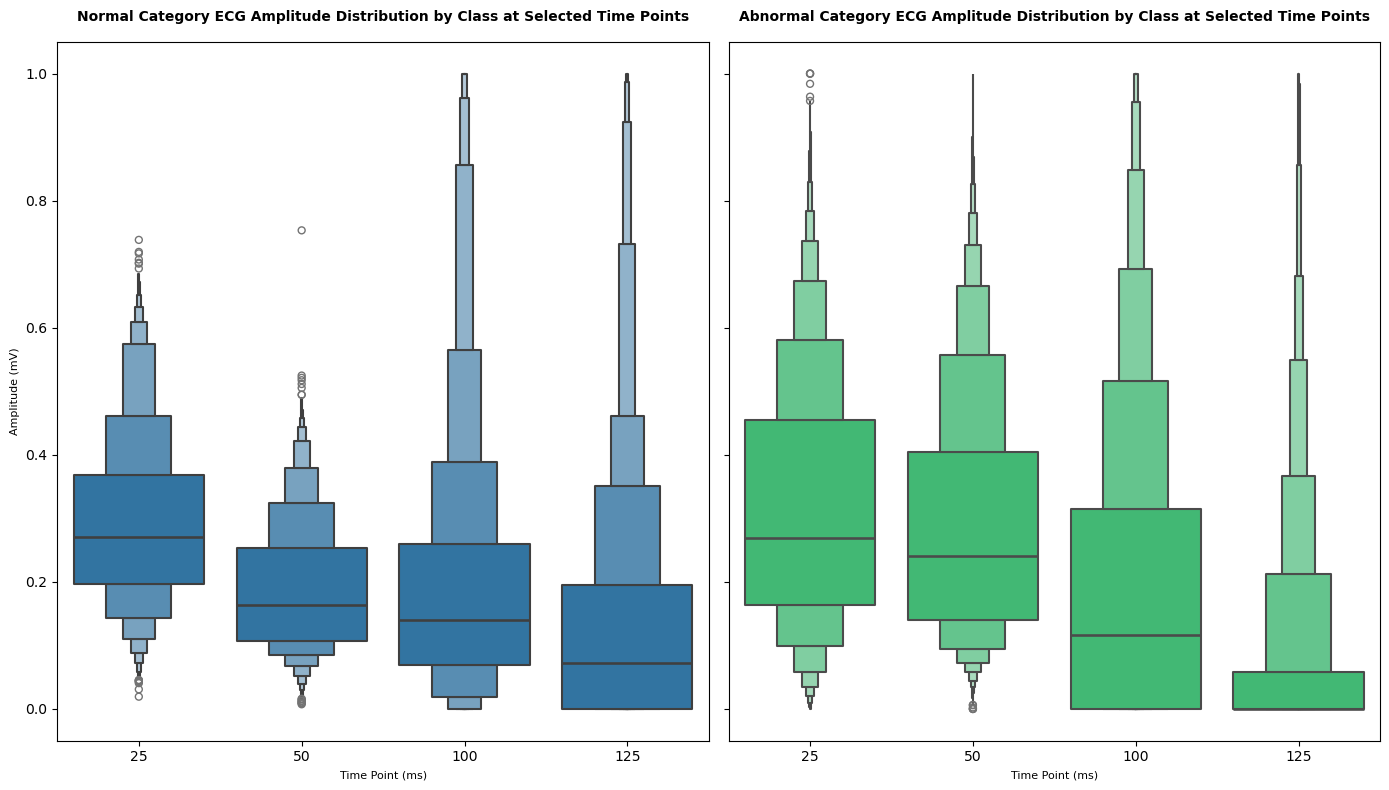

In [15]:
def visualize_informative_regions(
    normal: pd.DataFrame,
    abnormal: pd.DataFrame,
    time_points: list[int],
) -> None:
    """Visualizes variation/differences in selected time points.

    Args:
      normal : pd.DataFrame
        Dataframe that contains the normal ECG signal of a heart.
      abnormal : pd.DataFrame
        Dataframe that contains the abnormal ECG signal of a heart.
      time_points : list[int]
        The time points that might be visually an informative feature.

    Returns:
      Graphs two box plots. One for
    """

    # Create a df that containing the time points we want to visualize and the
    # values of those time points
    df_normal_melt = normal.melt(
        value_vars=time_points, var_name="Time Point", value_name="Amplitudes"
    )
    df_abnormal_melt = abnormal.melt(
        value_vars=time_points, var_name="Time Point", value_name="Amplitudes"
    )

    fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(14, 8))

    # Plotting normal first
    sns.boxenplot(
        data=df_normal_melt,
        x="Time Point",
        y="Amplitudes",
        dodge=True,
        linewidth=1.5,
        ax=axes[0],
    )
    axes[0].set_title(
        "Normal Category ECG Amplitude Distribution by Class at Selected Time Points",
        fontsize=10,  # Slightly smaller than a main title usually
        fontweight="bold",
        pad=15,
    )
    axes[0].set_xlabel("Time Point (ms)", fontsize=8)
    axes[0].set_ylabel("Amplitude (mV)", fontsize=8)

    # Plotting abnormal second
    sns.boxenplot(
        data=df_abnormal_melt,
        x="Time Point",
        y="Amplitudes",
        dodge=True,
        linewidth=1.5,
        ax=axes[1],
        color="#2ecc71",
    )
    axes[1].set_title(
        "Abnormal Category ECG Amplitude Distribution by Class at Selected Time Points",
        fontsize=10,
        fontweight="bold",
        pad=15,
    )
    axes[1].set_xlabel("Time Point (ms)", fontsize=8)
    axes[1].set_ylabel("Amplitude (mV)", fontsize=8)
    plt.tight_layout()
    plt.show()


visualize_informative_regions(
    normal=normal_df, abnormal=abnormal_df, time_points=[25, 50, 100, 125]
)

### Boxplot Graph Plotting analysis conclusions

_Note: When talking about the __T Wave__ we are talking about the __T wave before__, because it seems like the samples of the heart be are taken from R to R peak+padding_
1. __20ms and 50ms Time Point for normal__
   *  The 20ms should be the around the peak of the __T Wave__, the mV is ~0.7 at its highest.
   *  The 50ms mark should be the end of the __T Wave__, this is suggested by the decrease in mV as the mV is ~0.5 at its highest.
   *  These follow how I would expect the __T Wave__ to look like, has a peak, and then decreases slowly.
2. __100ms and 125ms Time Point for normal__
   *  Around 100ms, it seems to be the peak of the __QRS wave__, the mV is ~1 at its highest.
   *  Then around 125ms, it start rolling off.
   *  The __QRS Wave__ is sharp, but it gradually rolls off.

3. __20ms,50ms,100ms, and 125ms Time Point for abnormal__
   *  There seems to exist no peak for the identification of the __T Wave__.
   *  __QRS Wave__ exist, but does not last long.
  
This concludes that there is a mnorpholoical deviation between the __T Wave__ of the normal and the abnormal. As the __T Wave__ is not apparent at all. possibily indicating there is no significant replarization before the next __QRS Wave__.

### Statically Checks:
- do the normal or abnormal have data that are considered outliers?

To check if there are __outlier__ within the normal or abnormal dataset. We will preform __Focused Z-score outlier detection__. What that means is that we are trying to find heart beats signals that differ within their own category(i.e., normal and abnormal).

In [16]:
# Removing the classifications from the abnormal and normal dfs.
normal_X = normal_df.iloc[:, :-1].values
normal_y = normal_df[LABEL_COL]
abnormal_X = abnormal_df.iloc[:, :-1].values
abnormal_y = abnormal_df[LABEL_COL]
# The threshold is used to see how many times is a value
# greater or less than the average. The threshold is 9
# because the QRS wave will make it seem that every
# signal is an outlier because the QRS wave makes
# everything an outlier.
threshold = 9
# axis = 1 means that we are doing it cols by cols
z_scores_normal = np.abs(zscore(normal_X, axis=1))

outlier_normal_rows = np.where(np.max(z_scores_normal, axis=1) > threshold)[0]
if len(outlier_normal_rows) > 0:
    print(
        f"Normal Dataset: {len(outlier_normal_rows)} potential outlier signals (Z-score > {threshold})."
    )

# Abnormal
z_scores_abnormal = np.abs(zscore(abnormal_X, axis=1))
# This finds the rows where the z-score is
outlier_abnormal_rows = np.where(np.max(z_scores_abnormal, axis=1) > threshold)[0]
if len(outlier_abnormal_rows) > 0:
    print(
        f"Abnormal Dataset: {len(outlier_abnormal_rows)} potential outlier signals (Z-score > {threshold})."
    )

Normal Dataset: 5 potential outlier signals (Z-score > 9).
Abnormal Dataset: 7 potential outlier signals (Z-score > 9).


### Conclusion from outliers using Z-scores
- Since there are not a lot of outliers. that would speculate this could be to artifacts(i.e., some physiological or external presence that makes these different from the rest.) 


### Statisitical Feature Exploration
- __Mean__: At each time step, does the normal differ from the abnormal?
- __Variance__: At each time step, does the normal dataset have more differences compared to the abnormal, or is it the oppisite? 

The __Mean__ of normal and abnormal for each timestep will give us the average waveform of both the normal and the abnormal heatbeat.

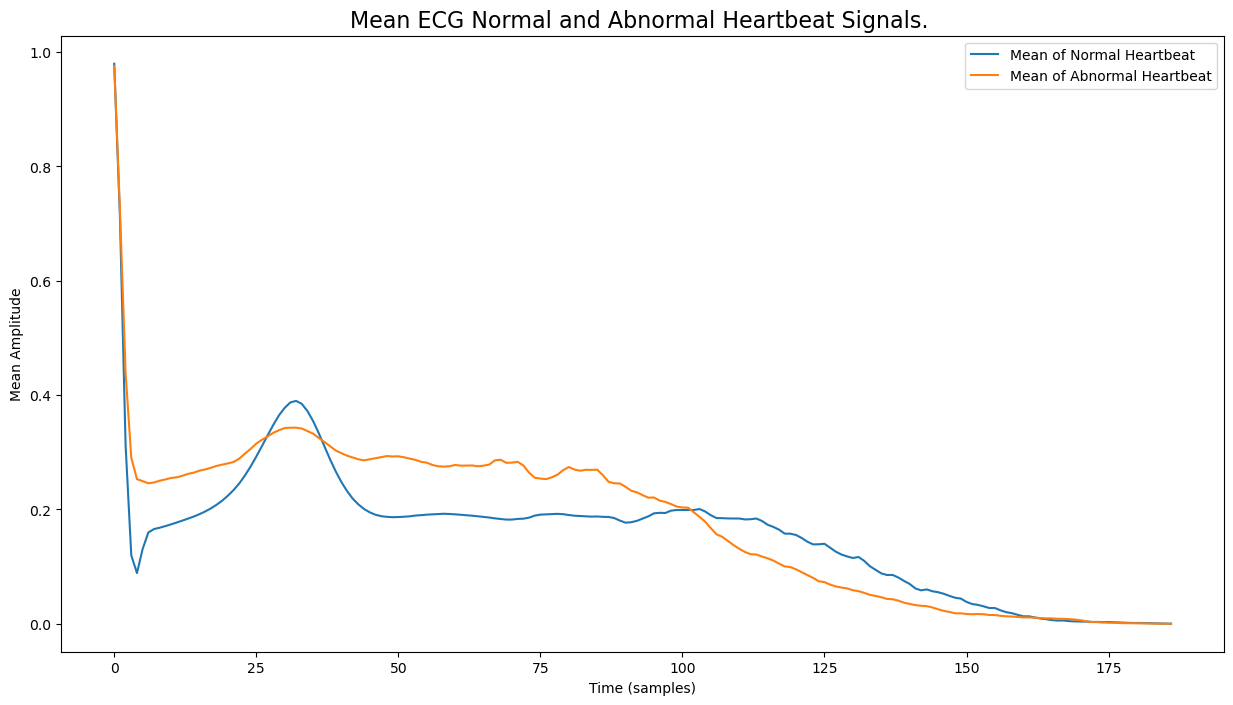

(187,)

In [17]:
plt.figure(figsize=(15, 8))
# We want the mean of each time step(i.e., column)
# so we do axis=0.
normal_signal_avg = normal_X.mean(axis=0)
abnormal_signal_avg = abnormal_X.mean(axis=0)
plt.plot(normal_signal_avg, label=f"Mean of Normal Heartbeat")
plt.plot(abnormal_signal_avg, label=f"Mean of Abnormal Heartbeat")
plt.title("Mean ECG Normal and Abnormal Heartbeat Signals. ", fontsize=16)
plt.xlabel("Time (samples)")
plt.ylabel("Mean Amplitude")
plt.legend()
plt.show()
normal_signal_avg.shape

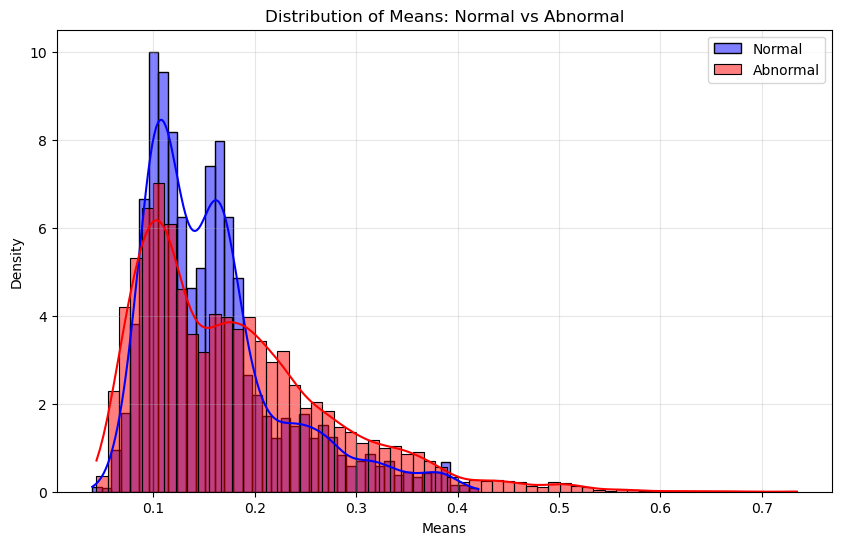

In [18]:
normal_signal_avg = normal_X.mean(axis=1)
abnormal_signal_avg = abnormal_X.mean(axis=1)
plt.figure(figsize=(10, 6))
sns.histplot(
    normal_signal_avg, color="blue", kde=True, label="Normal", stat="density", alpha=0.5
)
sns.histplot(
    abnormal_signal_avg,
    color="red",
    kde=True,
    label="Abnormal",
    stat="density",
    alpha=0.5,
)

plt.title("Distribution of Means: Normal vs Abnormal")
plt.xlabel("Means")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Conclusion from the Mean
- Taking the mean for all time steps show cases that its hard to differentiate the __T Wave before the second R Peak__ in the abnormal vs the normal. This might be due to the fact that the abnormal generally has more energy early. As if the abnormal do not experience a proper repolarization. 

We can also check the __spread__ of the heartbeat signal from the __mean__, also know as __variance__

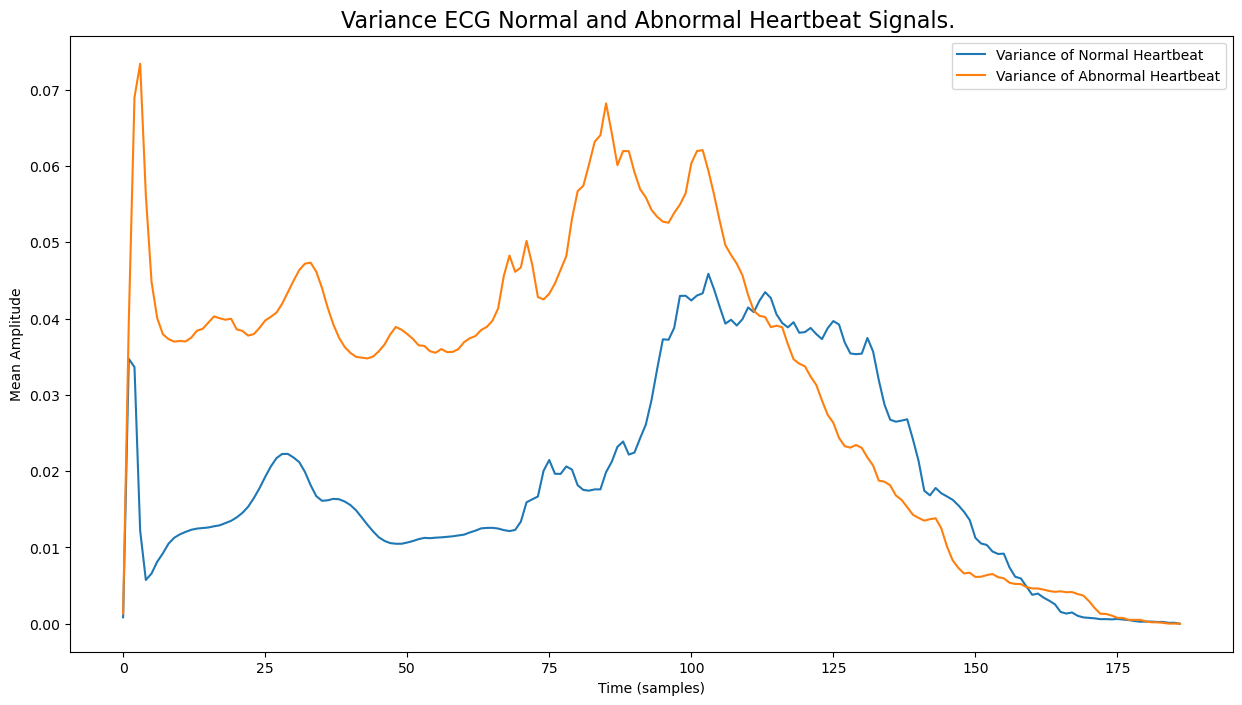

In [19]:
plt.figure(figsize=(15, 8))
# We want the mean of each time step(i.e., column)
# so we do axis=0.
normal_signal_var = normal_X.var(axis=0)
abnormal_signal_var = abnormal_X.var(axis=0)
plt.plot(normal_signal_var, label=f"Variance of Normal Heartbeat")
plt.plot(abnormal_signal_var, label=f"Variance of Abnormal Heartbeat")
plt.title("Variance ECG Normal and Abnormal Heartbeat Signals. ", fontsize=16)
plt.xlabel("Time (samples)")
plt.ylabel("Mean Amplitude")
plt.legend()
plt.show()

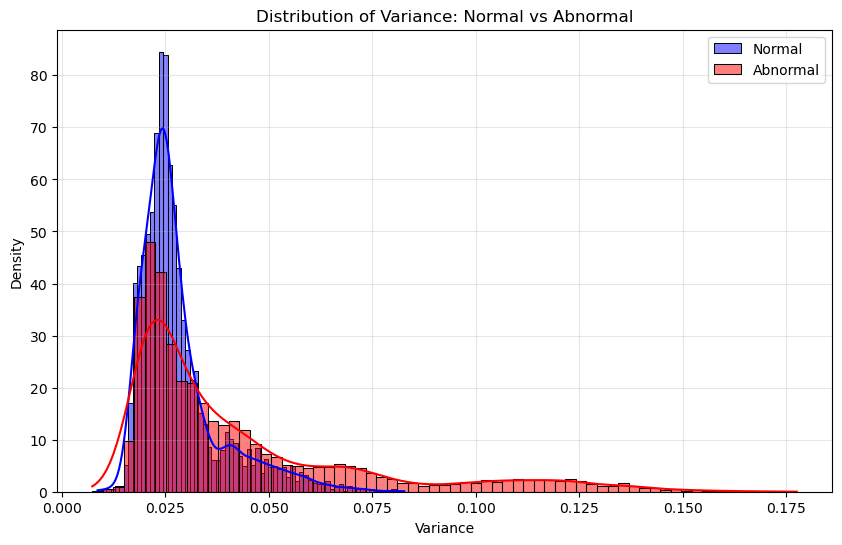

In [20]:
normal_signal_var = normal_X.var(axis=1)
abnormal_signal_var = abnormal_X.var(axis=1)
plt.figure(figsize=(10, 6))
sns.histplot(
    normal_signal_var, color="blue", kde=True, label="Normal", stat="density", alpha=0.5
)
sns.histplot(
    abnormal_signal_var,
    color="red",
    kde=True,
    label="Abnormal",
    stat="density",
    alpha=0.5,
)

plt.title("Distribution of Variance: Normal vs Abnormal")
plt.xlabel("Variance")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Conclusion from the Variance
- It makes sense that there is __variance__ in the abnormal compared to the normal. Since we assume that the normal will look more the same vs the abnormal might have __different diagnostics__. 

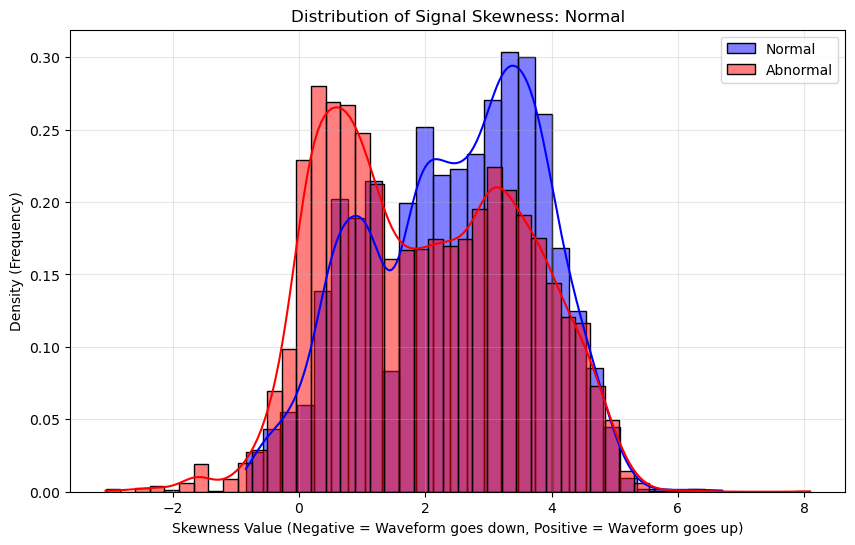

In [21]:
skewness_normal = skew(normal_X, axis=1)
skewness_abnormal = skew(abnormal_X, axis=1)
plt.figure(figsize=(10, 6))
sns.histplot(
    skewness_normal, color="blue", kde=True, label="Normal", stat="density", alpha=0.5
)
sns.histplot(
    skewness_abnormal,
    color="Red",
    kde=True,
    label="Abnormal",
    stat="density",
    alpha=0.5,
)
plt.title("Distribution of Signal Skewness: Normal")
plt.xlabel(
    "Skewness Value (Negative = Waveform goes down, Positive = Waveform goes up)"
)
plt.ylabel("Density (Frequency)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Conclusion for Skewness
- One can assume that there exist more of a __negative spike downwards__ in the __anomoly dataset__.
- Where as, there exist a more __postive spike upwards__ in the __normal dataset__.
- With these assumption in mind, we can assume there is more of a repolarization or the __energy__ of the __anomoly dataset__ is generally __higher__.

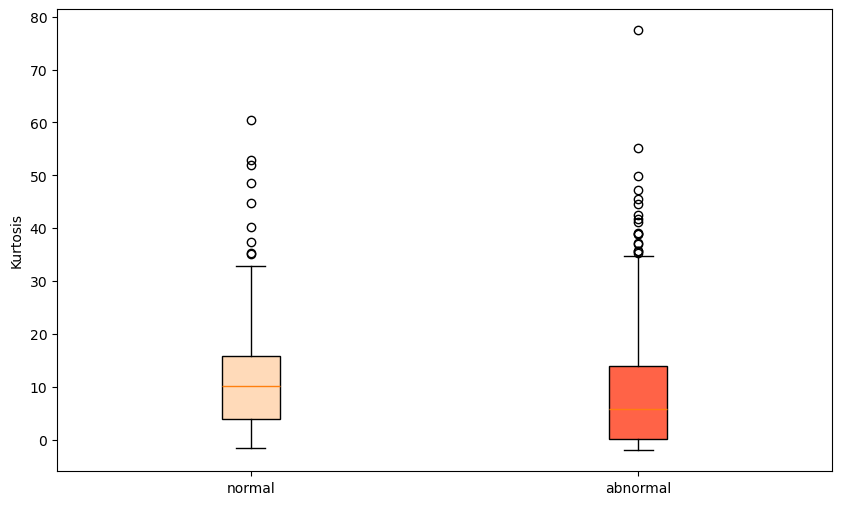

((4046,), (10506,))

In [22]:
labels = ["normal", "abnormal"]
normal_kurt = kurtosis(normal_X, axis=1)
abnormal_kurt = kurtosis(abnormal_X, axis=1)
kurt_plots = [normal_kurt, abnormal_kurt]
colors = ["peachpuff", "tomato"]
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_ylabel("Kurtosis")
bplot = ax.boxplot(kurt_plots, patch_artist=True, tick_labels=labels)
for patch, color in zip(bplot["boxes"], colors):
    patch.set_facecolor(color)

plt.show()
normal_kurt.mean(), abnormal_kurt.mean()
normal_kurt.shape, abnormal_kurt.shape

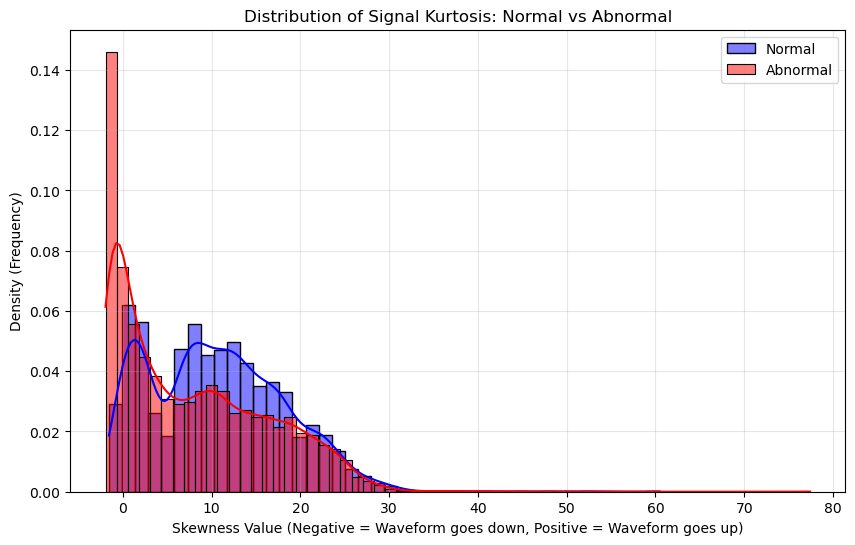

In [23]:
plt.figure(figsize=(10, 6))
sns.histplot(
    normal_kurt, color="blue", kde=True, label="Normal", stat="density", alpha=0.5
)
sns.histplot(
    abnormal_kurt,
    color="Red",
    kde=True,
    label="Abnormal",
    stat="density",
    alpha=0.5,
)
plt.title("Distribution of Signal Kurtosis: Normal vs Abnormal")
plt.xlabel(
    "Skewness Value (Negative = Waveform goes down, Positive = Waveform goes up)"
)
plt.ylabel("Density (Frequency)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Conclusion from kurtosis
- From both the __normal__ and the __abnormal__ seems like there is not a difference. __Abnormal__ might have a a less peak.

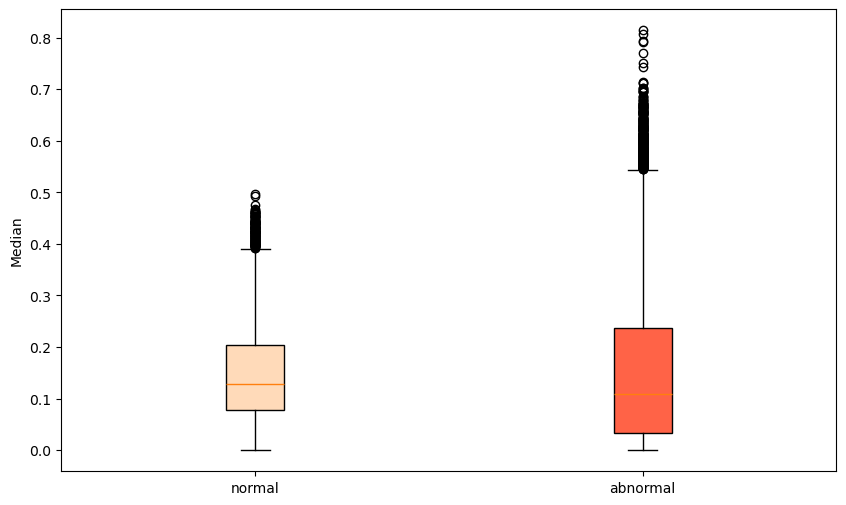

((4046,), (10506,))

In [24]:
normal_median = np.median(normal_X, axis=1)
abnormal_median = np.median(abnormal_X, axis=1)
median_plots = [normal_median, abnormal_median]
colors = ["peachpuff", "tomato"]
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_ylabel("Median")
bplot = ax.boxplot(median_plots, patch_artist=True, tick_labels=labels)
for patch, color in zip(bplot["boxes"], colors):
    patch.set_facecolor(color)

plt.show()
normal_median.shape, abnormal_median.shape

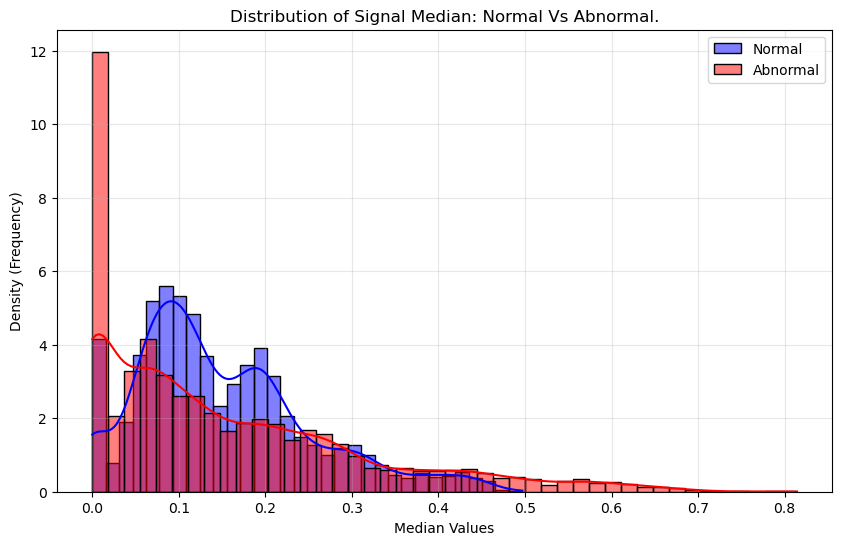

In [25]:
plt.figure(figsize=(10, 6))
sns.histplot(
    normal_median, color="blue", kde=True, label="Normal", stat="density", alpha=0.5
)
sns.histplot(
    abnormal_median,
    color="Red",
    kde=True,
    label="Abnormal",
    stat="density",
    alpha=0.5,
)
plt.title("Distribution of Signal Median: Normal Vs Abnormal.")
plt.xlabel("Median Values")
plt.ylabel("Density (Frequency)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [26]:
abnormal_median.mean(), normal_median.mean()

(np.float32(0.15447775), np.float32(0.1501975))

### Frequency Analysis
_Note: The starting point of the clip of data is probably affecting the freq present_

In [51]:
T = 1 / FS
N = len(normal_X[0])

# FFT
yf_normal = rfft(normal_X, axis=-1)
yf_abnormal = rfft(abnormal_X, axis=-1)

xf = rfftfreq(N, T)
yf_normal.shape, yf_abnormal.shape, xf.shape

((4046, 94), (10506, 94), (94,))

In [55]:
# Nyquist Frequency
nq = FS // 2
yf_normal = yf_normal[:, :nq]
yf_abnormal = yf_abnormal[:, :nq]
xf = xf[:nq]
xf.shape, yf_normal.shape, yf_abnormal.shape

((62,), (4046, 62), (10506, 62))

In [67]:
choose_rand_signal = np.random.randint(0, len(yf_normal))
choose_rand_signal

411

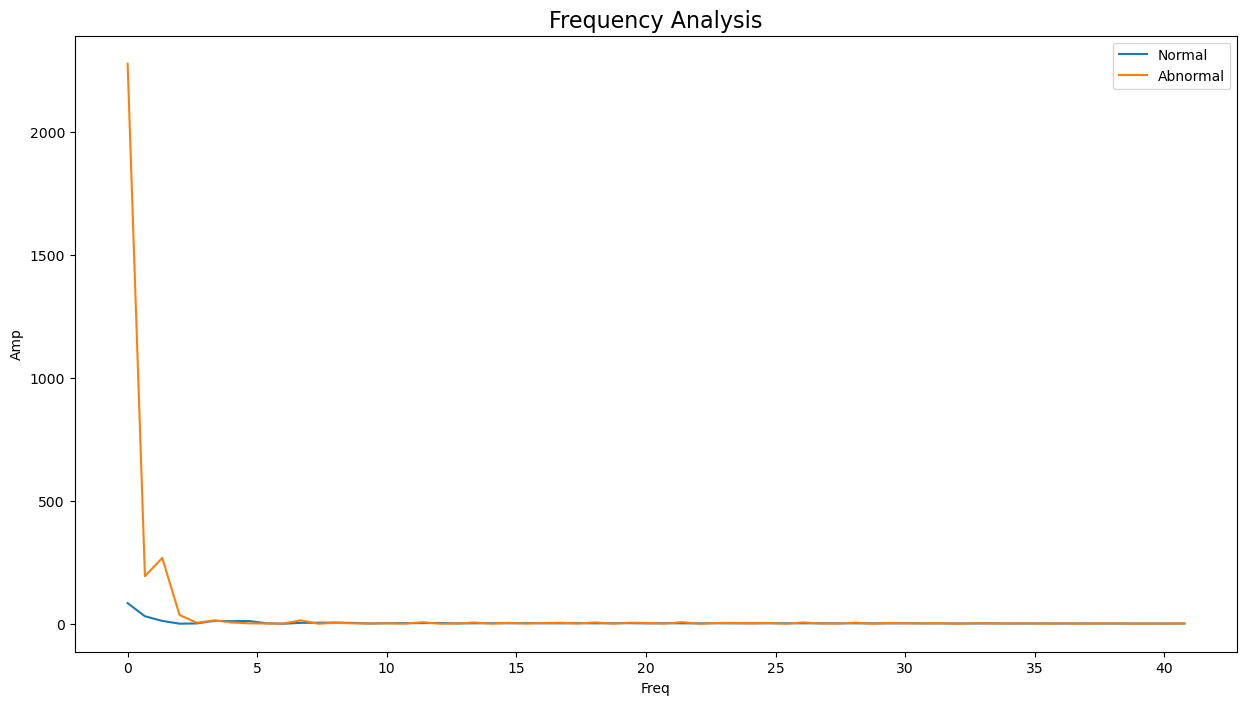

In [80]:
plt.figure(figsize=(15, 8))
choose_rand_signal = np.random.randint(0, len(yf_normal))
plt.plot(xf, np.abs(yf_normal[choose_rand_signal] ** 2), label=f"Normal")
plt.plot(xf, np.abs(yf_abnormal[choose_rand_signal] ** 2), label=f"Abnormal")
plt.title("Frequency Analysis", fontsize=16)
plt.xlabel("Freq")
plt.ylabel("Amp")
plt.legend()
plt.show()

### Conclusion Median
- There seems to be variation of median in __abnormal__ data but it seem the median is roughly the same.

### Feature Extraction
- we want to extract all the feature from the __abnormal__ and __normal__ dataset.
- The feature we want to extract fall into two categories __physical__ and __statistical__. The __physical__ categories are found in the __time domain__ and the __statistical__ are found in the __frequency domain__.
- 
The following features are sorted into the respective categories:

1. __Time domain - Statistical__
   * __Mean,Median,Standard Deviation, Skewness, Kurtosis__: ALlows us to understand how the amplitude is different abnormal vs normal. Additionally, how normal is similar to normal, and same with abnormal.
   * __Energy__: The sum of squared amplitudes.
   * __Max_value/R_Peak__: The maximum value of the signal. In other words, the __R Peak__ in the __QRS Wave__. 
   * __Minimum Value__: The minimum amplitude within a signal.
   * __Mean of Slope(First Derivatives)__: Captures the detrends. Checking if the rate of change and also if its generally increasing or decreasing.
   * __Zero-Crossing__: Since we know that its a real signal, this must mean its a sinusoidal waveform of some sort. therefore, it oscillates, and crosses the x-axis.
2. __Frequency Domain - Physical__ 
   * __Dominate Frequencies__: Going to take the largest frequency 

In [ ]:
X = df.iloc[:, :-1].values
y = df[LABEL_COL]

In [ ]:
def extract_time_domain(X: np.ndarray) -> None:
    """Extracts all the statistical and physical features from each signal.

    This is a dimentionality reduction process to reduce the number
    of feature we currently have.

    Args:
      X : np.ndarray
        2D array of signals. Where each row is a signaland each column is a timestep.

    Returns:
      Feature that reduces the dimentionality of timesteps.
    """
    means = X.mean(axis=1)
    std = X.var(axis=1)
    median = X.median(axis=1)
    energy = np.sum(X**2, axis=1)
    rPeak = np.max(X, axis=1)
    minValue = np.min(X, axis=1)
    slope_avg = np.mean(np.diff(X), axis=1)

    zero_crossing = np.sum(
        np.diff((np.sign(X - (X.mean(axis=1, keepdims=True))) >= 0), axis=1), axis=1
    )

### Resources
1. M. Kachuee, S. Fazeli and M. Sarrafzadeh, "ECG Heartbeat Classification: A Deep Transferable Representation," _2018 IEEE International Conference on Healthcare Informatics (ICHI)_, New York, NY, USA, 2018, pp. 443-444, doi: 10.1109/ICHI.2018.00092.
   